# A 1D example with Normal modes

In this example we will solve the classic error free SOLA problem in 1D:
$$
\begin{gather}
    \nonumber \text{Given the data constraint} \\ 
    d_i = G(m) = \int_0^1 K_i(x) m(x) dx \\
    \nonumber \text{We want to find} \\
    p_i = T(m) = \int_0^1 \Tau_i(x) m(x) dx
\end{gather}
$$

First we import the needed modules

In [28]:
import sys
sys.path.append('/home/adrian/PhD/BGSOLA/SOLA_DLI/core')
from core.main_classes.spaces import RN, PCb
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.mappings import *

# This contains various functions for loading and handling normal mode data 
from core.aux.normal_data import * 

Then we import the kernel data

In [29]:
# Directory where all the data is and whether we want vs or vp etc
data_directory = '/home/adrian/PhD/BGSOLA/mysola/normal_data/kernels_modeplotaat_Adrian'
kernel_type = 'vs'
# Read the file that contains all available modes 
kernel_discrete_domain, discrete_sensitivity_kernels = load_normal_data(kernel_type, data_directory)

This data is, however, discrete. We need the sensitivity kernels to be functions defined on a continuous domain. We create interpolation functions based on the discrete sensitivity kernels using the Interpolation_1D class in functions.py. (Important discussion: what errors are introduced by the discreteness of the sensitivity kernels and the choice of interpolation for it?)

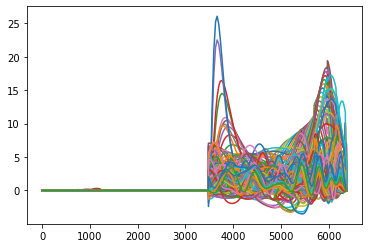

In [30]:
%matplotlib inline
# Create Earth 1D domain
EarthDomain = HyperParalelipiped(bounds=[[kernel_discrete_domain[0], 
                                          kernel_discrete_domain[-1]]], 
                                          fineness=1000)

sensitivity_kernels = []
how_many_kernels_to_load = 100#len(discrete_sensitivity_kernels)
for i, discrete_sensitivity_kernel in enumerate(discrete_sensitivity_kernels[0:how_many_kernels_to_load]):
    sensitivity_kernels.append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                raw_domain=kernel_discrete_domain,
                                                domain=EarthDomain))
    plt.plot(kernel_discrete_domain, discrete_sensitivity_kernel)

Then we create the needed spaces

In [31]:
# Create Model space
M = PCb(domain=EarthDomain)
# Create Data space (must know number of sensitivity kernels)
D = RN(dimension=len(sensitivity_kernels))
# Create Property space (must know number of target kernels)
no_targets = 10  # Number of targets we will use
P = RN(dimension=no_targets)


And the mappings. For the property mapping we also need to create some target kernels. 

In [32]:
# Create Data mapping (must have the sensitivity kernels)
G = IntegralMapping(domain=M, codomain=D, kernels=sensitivity_kernels)

# Create Target kernels
width = 1000 # same units as domain
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             no_targets)

target_kernels = []
for i in range(no_targets):
    target_kernels.append(Gaussian_1D(domain=EarthDomain,
                               center=enquiry_points[i],
                               width=width))
T = IntegralMapping(domain=M, codomain=P, kernels=target_kernels)

Now we generate some fake true model and data

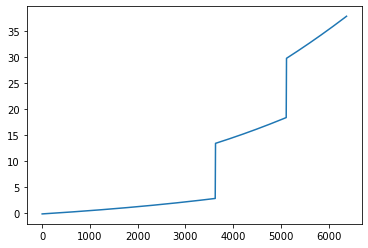

In [33]:
true_model = Random_1D(domain=EarthDomain, seed=1)
%matplotlib inline
true_model.plot()

data = G.map(true_model)

Now we obtain the least norm solution

In [34]:
# Find pseudo-inverse
G_adjoint = G.adjoint()
# Normally we would now compute this
"""G_pseudo_inverse = G_adjoint * (G * G_adjoint).invert()"""
# But computing (G * G_adjoint) is equivalent to computing the associated Gram
# matrix for the G mapping  which can be done faster with the method
# "_compute_GramMatrix()". The resulting Gram matrix can then be used to form a
# FiniteLinearMapping:
Lambda = G._compute_GramMatrix()
%matplotlib inline
print(Lambda.determinant)
# Now we can compute the gamma matrix
Gamma = T * G_adjoint

0.0


Now we want to compute the inverse of the Lambda matrix. This is oone of the most important and diifficult parts of SOLA. Because a direct inversion is just too unstable, we will use instead implicit inversion techniques. For this we use the ImplicitInvFiniteLinearMapping class. Instead of storing $A^{-1}$ it will store $A$. If we want to map a vector $v$ we will not do the matrix multiplication $A^{-1}v=x$, but rather we will solve $Ax=v$  

False
False

Entries with Significant Differences in Left Identity Matrix:
(0, 0): -0.004239201187002495
(0, 1): -0.12889883732292198
(0, 2): 0.30201600713452137
(0, 3): 0.04250343359922639
(0, 4): -0.1450535464884531
(0, 5): -0.020172379969289136
(0, 6): 0.15139579577503137
(0, 7): -0.15307811864321175
(0, 8): -0.08182421825221732
(0, 9): -0.10602071955100108
(0, 10): -0.20215680555797486
(0, 11): 0.14432704578678165
(0, 12): 0.17439784410753312
(0, 13): -0.09278836969162525
(0, 14): -0.008857964379742274
(0, 15): -0.14531075221973838
(0, 16): 0.24724759725294776
(0, 17): 0.20525602184753342
(0, 18): 0.29194556980247993
(0, 19): -0.15801429151011823
(0, 20): -0.19849693502249668
(0, 21): -0.1154846665345294
(0, 22): -0.24400798844457372
(0, 23): 0.07580774892404246
(0, 24): 0.12051019832188145
(0, 25): 0.044343488135161965
(0, 26): 0.0026063023718523003
(0, 27): -0.15917622315889596
(0, 28): 0.24222768436099273
(0, 29): -0.27298308650305897
(0, 30): 0.14539945137021842
(0, 31): 0.2642

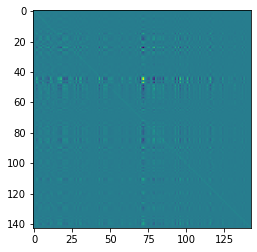

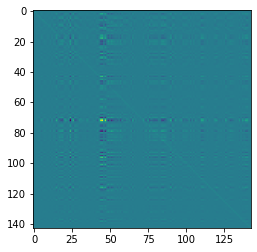

In [35]:
Lambda_inv = Lambda.invert(check_determinant=False)

# Now let's do some checks to see how good we can invert (implicitly) our
# matrix. Check if the inversion is good enough. We compute the left and right
# identities and check how close they get to the actual identitiy metrix.
left_identity = Lambda*Lambda_inv
right_identity = Lambda_inv*Lambda
# First a visual inspection (the diagonal should be all yellow and everything
# elese purple)
%matplotlib inline
plt.figure()
plt.imshow(left_identity.matrix)
plt.figure()
plt.imshow(right_identity.matrix)

# If you choose a low number of sensitivity kernels, then you may want to print
# the matrices and inspect them 
""" print(left_identity.matrix)
print(right_identity.matrix) """

# Now let's look more quantitatively: we look if all the entries are "close"
# enough to the entries in the identity matrix. We set a threshold for significant
# differences here. 
threshold = 1e-3
print(np.allclose(left_identity.matrix, np.eye(Lambda.matrix.shape[0]), atol=threshold))
print(np.allclose(right_identity.matrix, np.eye(Lambda.matrix.shape[0]), atol=threshold))

# Find where the matrices differ significantly from the identity matrix
left_difference = left_identity.matrix - np.eye(Lambda.matrix.shape[0])
right_difference = right_identity.matrix - np.eye(Lambda.matrix.shape[0])

# Iterate through the entries and print only those that differ beyond the threshold
print("\nEntries with Significant Differences in Left Identity Matrix:")
for i in range(left_difference.shape[0]):
    for j in range(left_difference.shape[1]):
        if abs(left_difference[i, j]) > threshold:
            print(f"({i}, {j}): {left_difference[i, j]}")

print("\nEntries with Significant Differences in Right Identity Matrix:")
for i in range(right_difference.shape[0]):
    for j in range(right_difference.shape[1]):
        if abs(right_difference[i, j]) > threshold:
            print(f"({i}, {j}): {right_difference[i, j]}")

# Try using fewer or more sensitivity kernels and then see how big/small the
# threshold becomes 

After "inverting" $\Lambda$ and made sure that numerical errors are not too big, we can compute $X$. 

<class 'core.main_classes.functions._SumFunction'>


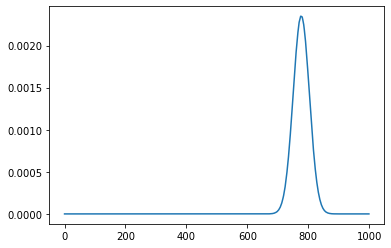

In [38]:
X = Gamma * Lambda_inv
resolving_kernels = np.dot(X.matrix, sensitivity_kernels)
print(type(resolving_kernels[0]))
%matplotlib inline
plt.plot(resolving_kernels[7].evaluate(EarthDomain.mesh)[1])